# Instructor Do: Intro to the ROC Curve and AUC

In this activity, students will learn how to measure the performance of a binary classification model by fetching metrics from Keras, as well as plotting and interpreting the ROC curve and AUC.

In [1]:
# Initial imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path

%matplotlib inline

## The Dataset

The data provided for this demo contains anonymous information about `284807` credit card transactions made by European credit cardholders in September 2013.

The dataset is going to be used to create a binary classification model using a deep neural network to detect fraudulent transactions. It contains nine numerical variables, which are the result of PCA transformation to protect the confidentiality of credit cardholders. Only the transaction amount can be seen as is.

This dataset is an abstract of the file shared by the [Machine Learning Group](http://mlg.ulb.ac.be) of the Université Libre de Bruxelles (ULB).

In [2]:
# Import the dataset
file_path = Path("../Resources/transactions.csv")
transactions_df = pd.read_csv(file_path)
transactions_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,69.99,0


## Data Preprocessing

In [3]:
# Creating the X and y sets
X = transactions_df.iloc[:, 0:10].values
y = transactions_df["Class"].values

In [4]:
# Import the StandardScaler from sklearn
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

Now that the data is scaled, the training, validation, and testing sets will be created.

In [5]:
# Creating training, validation, and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=78)

## Build and Train the Deep Learning Model

 ### Importing the Keras Modules

In [6]:
# Import Keras modules for model creation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

 ### Setting Up the Model

In [7]:
# Model set-up
number_input_features = 10
hidden_nodes_layer1 = 15
hidden_nodes_layer2 = 5

 ### Defining the Model's Structure

In [8]:
# Define the LSTM RNN model
model = Sequential()

# Layer 1
model.add(
    Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Layer 2
model.add(Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
model.add(Dense(1, activation="sigmoid"))

 ### Compiling the Model

In [9]:
# Compile the model
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[
        "accuracy",
        tf.keras.metrics.TruePositives(name="tp"),
        tf.keras.metrics.TrueNegatives(name="tn"),
        tf.keras.metrics.FalsePositives(name="fp"),
        tf.keras.metrics.FalseNegatives(name="fn"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ],
)

In [10]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15)                165       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 80        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 251
Trainable params: 251
Non-trainable params: 0
_________________________________________________________________


 ### Training the Model

In [11]:
# Training the model
batch_size = 1000
epochs = 50
training_history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
)

Train on 160203 samples, validate on 53402 samples
Epoch 1/50
160203/160203 [==============================] - 2s 15us/sample - loss: 0.3414 - accuracy: 0.9507 - tp: 2.0000 - tn: 152302.0000 - fp: 7644.0000 - fn: 255.0000 - precision: 2.6157e-04 - recall: 0.0078 - auc: 0.1482 - val_loss: 0.1189 - val_accuracy: 0.9980 - val_tp: 0.0000e+00 - val_tn: 53297.0000 - val_fp: 0.0000e+00 - val_fn: 105.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.1095
Epoch 2/50
160203/160203 [==============================] - 0s 3us/sample - loss: 0.0583 - accuracy: 0.9984 - tp: 0.0000e+00 - tn: 159946.0000 - fp: 0.0000e+00 - fn: 257.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.2089 - val_loss: 0.0298 - val_accuracy: 0.9980 - val_tp: 0.0000e+00 - val_tn: 53297.0000 - val_fp: 0.0000e+00 - val_fn: 105.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5054
Epoch 3/50
160203/160203 [==============================] - 0s 3us/sample - loss: 0.0202 - accuracy

### Model Performance

#### Checking Training History

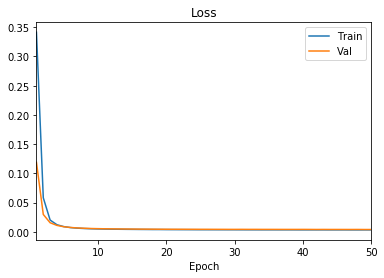

In [12]:
# Plotting loss
loss_df = pd.DataFrame(
    {
        "Epoch": range(1, epochs + 1),
        "Train": training_history.history["loss"],
        "Val": training_history.history["val_loss"],
    }
)
loss_df.set_index("Epoch", inplace=True)
loss_df.plot(title="Loss")

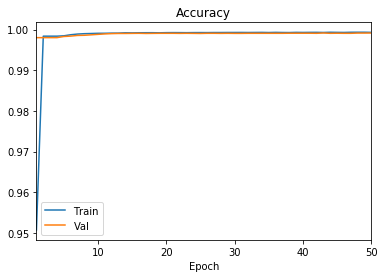

In [13]:
# Plotting accuracy
accuracy_df = pd.DataFrame(
    {
        "Epoch": range(1, epochs + 1),
        "Train": training_history.history["accuracy"],
        "Val": training_history.history["val_accuracy"],
    }
)
accuracy_df.set_index("Epoch", inplace=True)
accuracy_df.plot(title="Accuracy")

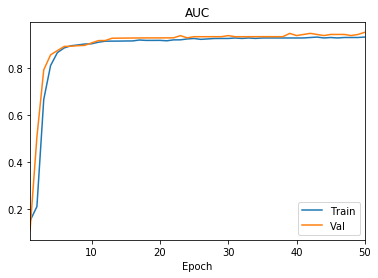

In [14]:
# Plotting AUC
auc_df = pd.DataFrame(
    {
        "Epoch": range(1, epochs + 1),
        "Train": training_history.history["auc"],
        "Val": training_history.history["val_auc"],
    }
)
auc_df.set_index("Epoch", inplace=True)
auc_df.plot(title="AUC")

#### Plotting the ROC Curve

In [15]:
# Import the roc_curve and auc metrics from sklearn
from sklearn.metrics import roc_curve, auc

In [16]:
# Making predictions to feed the roc_curve module
train_predictions = model.predict(X_train, batch_size=1000)
test_predictions = model.predict(X_test, batch_size=1000)

In [17]:
# Calculate the ROC curve and AUC for the training set
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, train_predictions)
auc_train = auc(fpr_train, tpr_train)
auc_train = round(auc_train, 4)

# Calculate the ROC curve and AUC for the testing set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, test_predictions)
auc_test = auc(fpr_test, tpr_test)
auc_test = round(auc_test, 4)

In [18]:
# Create a DataFrame with the fpr and tpr results
roc_df_train = pd.DataFrame({"FPR Train": fpr_train, "TPR Train": tpr_train,})

roc_df_test = pd.DataFrame({"FPR Test": fpr_test, "TPR Test": tpr_test,})

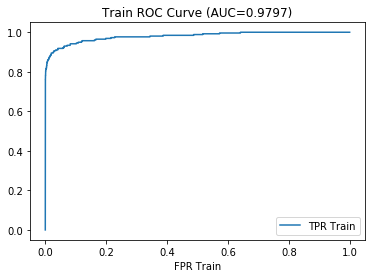

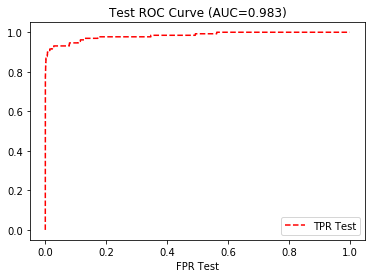

In [19]:
# Plotting the ROC Curves
roc_df_train.plot(
    x="FPR Train",
    y="TPR Train",
    xlim=([-0.05, 1.05]),
    title=f"Train ROC Curve (AUC={auc_train})",
)

roc_df_test.plot(
    x="FPR Test",
    y="TPR Test",
    color="red",
    style="--",
    xlim=([-0.05, 1.05]),
    title=f"Test ROC Curve (AUC={auc_test})",
)

#### Evaluate the Model

In [20]:
# Evaluate the model
scores = model.evaluate(X_test, y_test, verbose=0)

# Define metrics dictionary
metrics = {k: v for k, v in zip(model.metrics_names, scores)}

# Display evaluation metrics results
display(metrics)

{'loss': 0.003420691410458152,
 'accuracy': 0.99926966,
 'tp': 94.0,
 'tn': 71056.0,
 'fp': 16.0,
 'fn': 36.0,
 'precision': 0.8545455,
 'recall': 0.72307694,
 'auc': 0.9527449}

#### Confusion Matrix

In [21]:
# Define the confusion matrix data
cm_df = pd.DataFrame(
    {
        "Positive (1)": [f"TP={metrics['tp']}", f"FP={metrics['fn']}"],
        "Negative (0)": [f"FN={metrics['fp']}", f"TN={metrics['tn']}"],
    },
    index=["Positive(1)", "Negative(0)"],
)
cm_df.index.name = "Actual"
cm_df.columns.name = "Predicted"

# Show the confusion matrix
cm_df

Predicted,Positive (1),Negative (0)
Actual,,
Positive(1),TP=94.0,FN=16.0
Negative(0),FP=36.0,TN=71056.0


#### Classification Report

In [22]:
# Import the classification_report method from sklearn
from sklearn.metrics import classification_report

# Predict classes using testing data
y_predict_classes = model.predict_classes(X_test, batch_size=1000)

# Display classification report
print(classification_report(y_predict_classes, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71092
           1       0.72      0.85      0.78       110

    accuracy                           1.00     71202
   macro avg       0.86      0.93      0.89     71202
weighted avg       1.00      1.00      1.00     71202

